# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib import cm
from tqdm import tqdm

# Pre-processing

**Simualtion parameters and grid generation**

In [2]:
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0
num_grid_points = 101

ν = 0.1
ρ = 1.0
u_lid = 1.0

print(f'Re = {ρ*u_lid*(x_max-x_min)/ν}')

Re = 10.0


In [3]:
dx = (x_max-x_min)/(num_grid_points-1)
dy = (y_max-y_min)/(num_grid_points-1)
x = np.linspace(x_min, x_max, num_grid_points)
y = np.linspace(y_min, y_max, num_grid_points)
X, Y = np.meshgrid(x, y)

In [4]:
dt_max = min(0.25*dx**2./ν, 0.25*dy**2./ν)
dt = 0.0001

if dt > dt_max:
    raise RuntimeError('Numerical stability is not guranteed.')

In [5]:
tfinal = 1.0
num_time_steps = int(tfinal/dt)
num_ppe_iterations = 101

**Initialize arrays for u, v and p**

In [6]:
un = np.zeros_like(X)
vn = np.zeros_like(X)
pn = np.zeros_like(X)

**Creating functions for computing derivatives**

In [7]:
def dfdx_cd(f, dx):
    dfdx = np.zeros_like(f)
    dfdx[1:-1,1:-1] = (f[1:-1,2:] - f[1:-1,:-2])/(2.0*dx)
    return dfdx

In [8]:
def dfdy_cd(f, dy):
    dfdy = np.zeros_like(f)
    dfdy[1:-1,1:-1] = (f[2:,1:-1] - f[:-2,1:-1])/(2.0*dy)
    return dfdy

In [9]:
def laplace_cd(f, dx, dy):
    d2fdx2 = np.zeros_like(f)
    d2fdy2 = np.zeros_like(f)
    d2fdx2[1:-1,1:-1] = (f[1:-1,2:] - 2*f[1:-1,1:-1] + f[1:-1,:-2])/(dx**2.)
    d2fdy2[1:-1,1:-1] = (f[2:,1:-1] - 2*f[1:-1,1:-1] + f[:-2,1:-1])/(dy**2.)
    return d2fdx2 + d2fdy2

# Chorin's Projection Method

+ Compute the intermediate velocity

\begin{equation}
\frac{\mathbf{u}^{*}-\mathbf{u}^{n}}{\Delta t} = - \left(\mathbf{u}^{n} \cdot \nabla \right) \mathbf{u}^{n} + \nu \nabla^{2} \mathbf{u}^{n}. 
\end{equation}

+ Solve the elliptic problem for the pressure,

\begin{equation}
 \nabla^{2} p^{n+1} = \frac{\rho}{\Delta t} \nabla \cdot \mathbf{u}^{*}.
\end{equation}

+ Use the pressure to correct the velocity to be divergence-free

\begin{equation}
\frac{\mathbf{u}^{n+1}-\mathbf{u}^{*}}{\Delta t} = -\frac{\nabla p^{n+1}}{\rho}.
\end{equation}

In [10]:
def compute_convective_fluxes(un, vn, dx, dy):
    dundx = dfdx_cd(un,dx)
    dundy = dfdy_cd(un,dy)
    dvndx = dfdx_cd(vn,dx)
    dvndy = dfdy_cd(vn,dy)
    return dundx, dundy, dvndx, dvndy

In [11]:
def compute_diffusive_fluxes(un, vn, dx, dy):
    laplace_un = laplace_cd(un, dx, dy)
    laplace_vn = laplace_cd(vn, dx, dy)
    return laplace_un, laplace_vn

In [12]:
def compute_temp_velocities(un, vn, dx, dy, ν, dt):
    dundx, dundy, dvndx, dvndy = compute_convective_fluxes(un, vn, dx, dy)
    laplace_un, laplace_vn = compute_diffusive_fluxes(un, vn, dx, dy)
    
    ut = un - dt*(un*dundx + vn*dundy) + ν*dt*laplace_un
    vt = vn - dt*(un*dvndx + vn*dvndy) + ν*dt*laplace_vn
    
    # Apply velocity boundary conditions : no slip conditions at the solid boundaries
    ut[0,:] = 0.0      # bottom wall u vel 
    ut[:,0] = 0.0      # left wall u vel
    ut[:,-1] = 0.0     # right wall u vel
    ut[-1,:] = u_lid   # top wall u vel
    vt[0,:] = 0.0      # bottom wall v vel
    vt[:,0] = 0.0      # left wall v vel
    vt[:,-1] = 0.0     # right wall v vel
    vt[-1,:] = 0.0     # top wall v vel
    
    return ut, vt

In [13]:
def projection_step(ut, vt, dx, dy, pn):
    # Compute divergenc of temporary velocity field
    dutdx = dfdx_cd(ut, dx)
    dvtdy = dfdy_cd(vt, dy)
    
    # Projection step
    # Compute pressure correction by solving the pressure-poisson equation
    rhs = (ρ/dt)*(dutdx + dvtdy)
    
    pnp1 = np.zeros_like(pn)
    
    for _ in range(num_ppe_iterations):
        pnp1[1:-1,1:-1] = 0.5*((pn[1:-1,2:]+pn[1:-1,:-2])*(dy**2.0) + (pn[2:,1:-1]+pn[:-2,1:-1])*(dx**2.0) 
            - rhs[1:-1,1:-1]*(dx**2.0)*(dy**2.0))/(dx**2.0+dy**2.0)
        
        # Pressure boundary conditions : neumann boundary conditions (no-flow across the solid boundaries)
        # except for the top moving wall, where it is homogenous dirichlet b.c.
        pnp1[:,0] = pnp1[:,1]     # left wall
        pnp1[:,-1] = pnp1[:,-2]   # right wall
        pnp1[0,:] = pnp1[1,:]     # bottom wall
        pnp1[-1,:] = 0.0          # top wall
        
        pn = pnp1.copy()
    
    return pnp1

In [14]:
def correct_velocity_field(ut, vt, pnp1, dx, dy, ρ,dt):
    # Compute grad(p)
    dpn1dx = dfdx_cd(pnp1,dx)
    dpn1dy = dfdy_cd(pnp1,dy)
    
    # Correct the velocities such that the incompressibility constraint is satisfied
    unp1 = ut - (dt/ρ)*dpn1dx
    vnp1 = vt - (dt/ρ)*dpn1dy
    
    # Boundary Conditions - No slip boundary conditions on velocity
    unp1[0,:] = 0.0
    unp1[:,0] = 0.0
    unp1[:,-1] = 0.0
    unp1[-1,:] = u_lid
    vnp1[0,:] = 0.0
    vnp1[:,0] = 0.0
    vnp1[:,-1] = 0.0
    vnp1[-1,:] = 0.0
    
    return unp1, vnp1

**Peform the simulation**

In [15]:
un = np.zeros_like(X)
vn = np.zeros_like(X)
pn = np.zeros_like(X)

for _ in tqdm(range(num_time_steps)):
    # Step 1
    ut, vt = compute_temp_velocities(un, vn, dx, dy, ν, dt)
    # Step 2
    pnp1 = projection_step(ut, vt, dx, dy, pn)
    # Step 3
    unp1, vnp1 = correct_velocity_field(ut, vt, pnp1, dx, dy, ρ,dt)
    # Update arrays for time marching
    # Update arrays for time marching
    un = unp1.copy()
    vn = vnp1.copy()
    pn = pnp1.copy()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 145.21it/s]


# Post-processing and Visualization

**Plotting velocity field and streamlines**

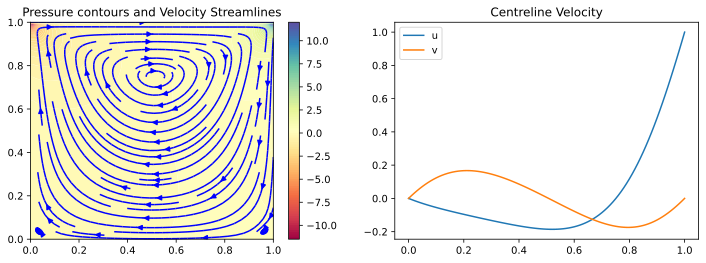

In [16]:
#plt.style.use("dark_background")
fig = plt.figure(figsize=[12,4],dpi=600)
ax = plt.subplot(1,2,1)
pcont = plt.contourf(X,Y,pnp1, levels=100, cmap=plt.cm.Spectral)
plt.colorbar(pcont)

#plt.quiver(X,Y,unp1,vnp1,color='black')
plt.streamplot(X,Y,unp1,vnp1,color='blue')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Pressure contours and Velocity Streamlines')
#plt.axis('equal')

plt.subplot(1,2,2)
plt.plot(y,unp1[:,int(num_grid_points/2)])
plt.plot(x,vnp1[int(num_grid_points/2),:])
plt.legend(['u','v'])
#plt.axis('equal')
plt.title('Centreline Velocity')

plt.show()